# Milestone Project 1: Food Vision Big

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f310a571-0dc8-a56d-384d-28d0b3c33d63)


## Get helper functions

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-13 08:51:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-13 08:51:11 (84.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (take 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompletePDVU1V/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompletePDVU1V/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 64
  Class name (str form): miso_soup
  


In [ ]:
# min and max values of our image
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

###Plot an image from TensorFlow Datasets

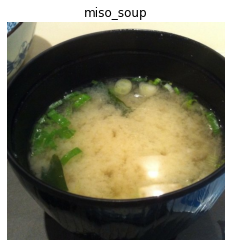

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 48.969387  93.68367  129.04082 ]
  [124.78572  164.07144  195.28572 ]
  [125.37245  158.94388  183.5153  ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]

 [[ 65.28572  108.688774 143.09183 ]
  [129.93878  169.09184  200.17348 ]
  [ 79.61224  115.04081  140.88266 ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

https://www.tensorflow.org/guide/mixed_precision

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32") # set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<Policy "float32">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "float32">
normalization_2 False float32 <Policy "float32">
tf.math.truediv_2 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [ ]:
mixed_precision.global_policy()

<Policy "float32">

## Fit the feature extraction model

In [ ]:
# Fit the feature extraction model with callbacks
history_1001_food_classes_feature_extract = model.fit(train_data,
                                                      epochs=3,
                                                      steps_per_epoch=(len(train_data)),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)),
                                                      callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                             experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230113-091150
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7186 - accuracy: 0.5814

2368/2368 [==============================] - 226s 89ms/step - loss: 1.7186 - accuracy: 0.5814 - val_loss: 1.1268 - val_accuracy: 0.6986
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2004 - accuracy: 0.6904

2368/2368 [==============================] - 185s 77ms/step - loss: 1.2004 - accuracy: 0.6904 - val_loss: 1.0203 - val_accuracy: 0.7211
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0552 - accuracy: 0.7233

2368/2368 [==============================] - 185s 77ms/step - loss: 1.0552 - accuracy: 0.7234 - val_loss: 0.9876 - val_accuracy: 0.7246


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 55s 70ms/step - loss: 0.9971 - accuracy: 0.7281


[0.9971233606338501, 0.7280791997909546]